## Описание задачи

Задача проекта: Предсказать какие пассажиры спасутся с тонущего Титаника

## Загрузка необходимых методов

In [533]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer

import warnings
warnings.filterwarnings('ignore') # отключаем сообщения об ошибках pandas
pd.set_option('display.max_columns', None) # Сброс ограничений на число выводимых столбцов
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import torch.nn as nn # импорт библиотеки для построения нейросети
import torch
import random
from torchmetrics import ROC
import numpy as np
from math import ceil
from torchmetrics import MetricCollection, Accuracy, Precision, Recall
from sklearn.metrics import accuracy_score

## Загрузка данных

In [6]:
def read_csv(link):
    link1 = 'datasets/' + link
    link2 = '/datasets/' + link
    try:
        name_link = pd.read_csv(link1)
    except:
        name_link = pd.read_csv(link2)
    print('просмотрим первые пять строк')
    display(name_link.head())
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print('просмотрим информацию')
    display(name_link.info())
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print('посчитаем уникальные значения')
    display(name_link.nunique()) 
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print('проверим имена столбцов')
    display(name_link.columns) 
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print('проверка на явные дубликаты')
    display('Количество явных дубликатов:', name_link.duplicated().sum()) 
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print('проверим численные данные')
    display(name_link.describe()) 
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print('проверим корреляции')
    display(name_link.corr())
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    return name_link

In [395]:
data_train = read_csv("train.csv")

просмотрим первые пять строк


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
просмотрим информацию
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
посчитаем уникальные значения


PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
проверим имена столбцов


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
проверка на явные дубликаты


'Количество явных дубликатов:'

0

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
проверим численные данные


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
проверим корреляции


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [396]:
data_test1 = read_csv("test.csv")

просмотрим первые пять строк


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
просмотрим информацию
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


None

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
посчитаем уникальные значения


PassengerId    418
Pclass           3
Name           418
Sex              2
Age             79
SibSp            7
Parch            8
Ticket         363
Fare           169
Cabin           76
Embarked         3
dtype: int64

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
проверим имена столбцов


Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
проверка на явные дубликаты


'Количество явных дубликатов:'

0

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
проверим численные данные


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
проверим корреляции


,PassengerId,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.026751,-0.034102,0.003818,0.043080,0.008211
Pclass,-0.026751,1.000000,-0.492143,0.001087,0.018721,-0.577147
Age,-0.034102,-0.492143,1.000000,-0.091587,-0.061249,0.337932
SibSp,0.003818,0.001087,-0.091587,1.000000,0.306895,0.171539
Parch,0.043080,0.018721,-0.061249,0.306895,1.000000,0.230046
Fare,0.008211,-0.577147,0.337932,0.171539,0.230046,1.000000


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [397]:
data_test = read_csv("test.csv")

просмотрим первые пять строк


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
просмотрим информацию
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


None

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
посчитаем уникальные значения


PassengerId    418
Pclass           3
Name           418
Sex              2
Age             79
SibSp            7
Parch            8
Ticket         363
Fare           169
Cabin           76
Embarked         3
dtype: int64

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
проверим имена столбцов


Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
проверка на явные дубликаты


'Количество явных дубликатов:'

0

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
проверим численные данные


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
проверим корреляции


,PassengerId,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.026751,-0.034102,0.003818,0.043080,0.008211
Pclass,-0.026751,1.000000,-0.492143,0.001087,0.018721,-0.577147
Age,-0.034102,-0.492143,1.000000,-0.091587,-0.061249,0.337932
SibSp,0.003818,0.001087,-0.091587,1.000000,0.306895,0.171539
Parch,0.043080,0.018721,-0.061249,0.306895,1.000000,0.230046
Fare,0.008211,-0.577147,0.337932,0.171539,0.230046,1.000000


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++


<b>Описание столбцов</b>

'PassengerId' - номер пассажира

'Survived' - спасся или нет

'Pclass' - класс билета

'Name' - имя

'Sex' - пол

'Age' - возраст

'SibSp' - есть ли супруг на борту

'Parch' - есть ли дети на борту

'Ticket' - номер билета

'Fare' - тариф билета

'Cabin' - номер каюты

'Embarked' - Порт посадки


## Обработка данных

In [398]:
gender_labels = {'male':0,'female':1}
data_train['Sex'] = data_train['Sex'].replace({'male':0,'female':1})

In [399]:
data_train = data_train.drop(['Name','Cabin', 'PassengerId', 'Ticket'],axis =1)
data_test = data_test.drop(['Name','Cabin', 'PassengerId', 'Ticket'],axis =1)

In [400]:
data_train['Age'] = data_train['Age'].fillna(data_train['Age'].mean())

In [401]:
data_test['Age'] = data_test['Age'].fillna(data_test['Age'].mean())
data_test['Fare'] = data_test['Fare'].fillna(data_test['Fare'].mean())
gender_labels = {'male':0,'female':1}
data_test['Sex'] = data_test['Sex'].replace({'male':0,'female':1})

In [402]:
data_train.dropna(subset = ['Embarked'],inplace = True)

In [403]:
x_train1 = data_train.drop(['Survived'],axis =1)   #dropped unnecessary columns

In [404]:
y_train_ohe = data_train['Survived']

In [405]:
y_train1 = data_train['Survived']

In [406]:
x_test = data_test

In [407]:
num_columns = list(x_test.columns)

## OHE и масштабирование

In [408]:
x_train_ohe = pd.get_dummies(x_train1, columns=['Embarked'])
x_train_ohe.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,3,0,22.0,1,0,7.2500,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,0
2,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,3,0,35.0,0,0,8.0500,0,0,1


In [409]:
x_test = pd.get_dummies(x_test, columns=['Embarked'])
x_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,3,0,34.5,0,0,7.8292,0,1,0
1,3,1,47.0,1,0,7.0000,0,0,1
2,2,0,62.0,0,0,9.6875,0,1,0
3,3,0,27.0,0,0,8.6625,0,0,1
4,3,1,22.0,1,1,12.2875,0,0,1


In [410]:
x_train1, x_valid, y_train1, y_valid = train_test_split(x_train_ohe, y_train1, stratify=y_train1,
                                                    test_size=0.20, shuffle=True, random_state=12345)

In [411]:
numeric = ['Pclass', 'Age', 'Fare']

scaler = StandardScaler()

scaler.fit(x_train1[numeric])

StandardScaler()

In [412]:
x_train1[numeric] = scaler.transform(x_train1[numeric])
x_valid[numeric] = scaler.transform(x_valid[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])

x_train_ohe[numeric] = scaler.transform(x_train_ohe[numeric])

In [413]:
y_train1.value_counts(normalize=True)*100

0    61.744023
1    38.255977
Name: Survived, dtype: float64

In [414]:
from sklearn.utils import shuffle

In [415]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12347)
    
    return features_downsampled, target_downsampled

In [545]:
x_train, y_train = downsample(x_train1, y_train1, 0.77)

In [561]:
x_train_oh, y_train_oh = downsample(x_train_ohe, y_train_ohe, 0.65)

In [562]:
y_train_oh.value_counts(normalize=True)*100

0    51.219512
1    48.780488
Name: Survived, dtype: float64

In [563]:
y_train.value_counts(normalize=True)*100

0    55.409836
1    44.590164
Name: Survived, dtype: float64

In [564]:
from sklearn.model_selection import GridSearchCV

In [565]:
parameters = {'depth'         : [4,5,6,7,8,9, 10],
                 'learning_rate' : [0.01,0.02,0.03,0.04],
                  'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
                 }

In [566]:
%%time
cc = CatBoostClassifier(silent=True, thread_count = -1)
clf = GridSearchCV(cc, parameters, scoring = 'roc_auc', cv = 6, n_jobs=-1)
clf.fit(x_train_oh, y_train_oh)

CPU times: total: 3.67 s
Wall time: 1min 13s


GridSearchCV(cv=6,
             estimator=<catboost.core.CatBoostClassifier object at 0x000002892DE4CAC0>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6, 7, 8, 9, 10],
                         'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                        100],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04]},
             scoring='roc_auc')

In [567]:
clf.best_score_

0.8540532858747624

In [568]:
clf.best_params_

{'depth': 4, 'iterations': 100, 'learning_rate': 0.04}

ROC AUC: 0.8879679144385026
Полнота: 0.7205882352941176
Точность: 0.8596491228070176
accuracy valid: 0.848314606741573


confusion matrix for CAT BOOST


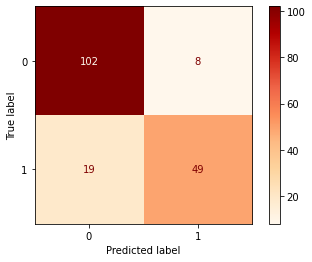

In [546]:
from catboost import CatBoostClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

cc = CatBoostClassifier(silent=True, thread_count = -1, iterations=80, depth=3, learning_rate=0.2)
model12=cc.fit(x_train, y_train)

predictions = model12.predict(x_valid)

ccpred = cc.predict(x_valid)
probabilities_valid_сс = model12.predict_proba(x_valid)
probabilities_one_valid_сс = probabilities_valid_сс[:, 1]
roc_auc_cat = roc_auc_score(y_valid, probabilities_one_valid_сс)
rec_cat = recall_score(y_valid, predictions)
prec_cat = precision_score(y_valid, predictions)                            

print('ROC AUC:', roc_auc_cat)
print('Полнота:', rec_cat)
print('Точность:', prec_cat)
print('accuracy valid:', accuracy_score(y_valid, predictions))

print("\n")
print("confusion matrix for CAT BOOST")
displr = plot_confusion_matrix(cc, x_valid, y_valid,cmap=plt.cm.OrRd , values_format='d')

In [569]:
cc = CatBoostClassifier(silent=True, thread_count = -1, iterations=100, depth=4, learning_rate=0.04)
model1=cc.fit(x_train_oh, y_train_oh)

In [387]:
x_train_ohe.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0.825561,0,-0.612130,1,0,-0.493770,0,0,1
1,-1.585010,1,0.667871,1,0,0.751700,1,0,0
2,0.825561,1,-0.292130,0,0,-0.480641,0,0,1
3,-1.585010,1,0.427871,1,0,0.398028,0,0,1
4,0.825561,0,0.427871,0,0,-0.478210,0,0,1


In [379]:
x_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0.825561,0,0.387871,0,0,-0.482504,0,1,0
1,0.825561,1,1.387871,1,0,-0.498633,0,0,1
2,-0.379724,0,2.587872,0,0,-0.446360,0,1,0
3,0.825561,0,-0.212130,0,0,-0.466296,0,0,1
4,0.825561,1,-0.612130,1,1,-0.395789,0,0,1
...,...,...,...,...,...,...,...,...,...
413,0.825561,0,0.049677,0,0,-0.478210,0,0,1
414,-1.585010,1,0.747871,0,0,1.483357,1,0,0
415,0.825561,0,0.707871,0,0,-0.493770,0,0,1
416,0.825561,0,0.049677,0,0,-0.478210,0,0,1


In [570]:
y_test = model1.predict(x_test)

In [571]:
sur = sum(y_test)/len(y_test)
print(sur)

0.39952153110047844


In [572]:
ids = data_test1['PassengerId'].tolist()

In [573]:
preds = list(y_test)

In [574]:
submission = {
    "PassengerID":[],
    "Survived":[]
}

In [575]:
from tqdm import tqdm

In [576]:
# preds = preds[:10]
# ids = ids[:10]
# First 10

In [577]:
for id,pred in zip(tqdm(ids),preds):
    submission['PassengerID'].append(id)
    submission['Survived'].append(pred)

100%|████████████████████████████████████████████████████████████████████████████████████████| 418/418 [00:00<?, ?it/s]


In [578]:
submission = pd.DataFrame(submission)

In [579]:
submission.iloc[:10]

,PassengerID,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [580]:
submission.to_csv("./test9.csv",index=False)

In [591]:
X_train = torch.FloatTensor(x_train.values)
X_test = torch.FloatTensor(x_valid.values)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_valid.values)

In [593]:
from torchmetrics import AUROC

In [599]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)


n_in_neurons = 9
n_hidden_neurons_1 = 10
n_hidden_neurons_2 = 10
n_out_neurons = 1 

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons), 
    nn.Sigmoid()
)



optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss = nn.BCELoss()

batch_size = 20

num_epochs = 200

num_batches = ceil(len(X_train)/batch_size)

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))# создайте случайную перестановку индексов объектов
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size# посчитайте номер стартового объекта батча
        optimizer.zero_grad()
  
        batch_indexes = order[start_index:start_index+batch_size]# извлеките индексы объектов текущего обатча
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
  
        preds = net.forward(X_batch).flatten()
    
        loss_value = loss(preds, y_batch)

        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        net.eval()
        with torch.no_grad():
            test_preds = net.forward(X_test)
            accuracy = (torch.round(test_preds) == y_test).float().mean().data
            auroc = AUROC(pos_label=1)
            roc_auc = auroc(torch.FloatTensor(sum(test_preds.tolist(), [])), y_test.int())
            print('accuracy -', accuracy)
            print('ROC_AUC-', roc_auc)
        
        net.train()

accuracy - tensor(0.5146)
ROC_AUC- tensor(0.6255)
accuracy - tensor(0.5358)
ROC_AUC- tensor(0.8906)
accuracy - tensor(0.5411)
ROC_AUC- tensor(0.8955)
accuracy - tensor(0.5424)
ROC_AUC- tensor(0.8917)
accuracy - tensor(0.5424)
ROC_AUC- tensor(0.8963)
accuracy - tensor(0.5424)
ROC_AUC- tensor(0.8957)
accuracy - tensor(0.5424)
ROC_AUC- tensor(0.8972)
accuracy - tensor(0.5371)
ROC_AUC- tensor(0.8977)
accuracy - tensor(0.5398)
ROC_AUC- tensor(0.8999)
accuracy - tensor(0.5398)
ROC_AUC- tensor(0.9008)
accuracy - tensor(0.5411)
ROC_AUC- tensor(0.9003)
accuracy - tensor(0.5371)
ROC_AUC- tensor(0.9020)
accuracy - tensor(0.5384)
ROC_AUC- tensor(0.9031)
accuracy - tensor(0.5384)
ROC_AUC- tensor(0.9008)
accuracy - tensor(0.5371)
ROC_AUC- tensor(0.9007)
accuracy - tensor(0.5424)
ROC_AUC- tensor(0.8992)
accuracy - tensor(0.5437)
ROC_AUC- tensor(0.8968)
accuracy - tensor(0.5371)
ROC_AUC- tensor(0.8965)
accuracy - tensor(0.5451)
ROC_AUC- tensor(0.8971)
accuracy - tensor(0.5437)
ROC_AUC- tensor(0.8972)
